# Forecasting taxi orders

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Let's build a model for such a prediction.

The *RMSE* metric value on the test sample should be no more than 48.

We need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column (from the English *number of orders*, “number of orders”).

# Description of data

The number of orders is in the 'num_orders' column (from the English number of orders, “number of orders”).

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

display(df.head())
print(df.info())
print(df.describe())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


Let's group the dates by 1 hour.

In [2]:
df = df.resample('1H').sum()

## Analysis

Let's display the moving average

Text(0, 0.5, 'frequency')

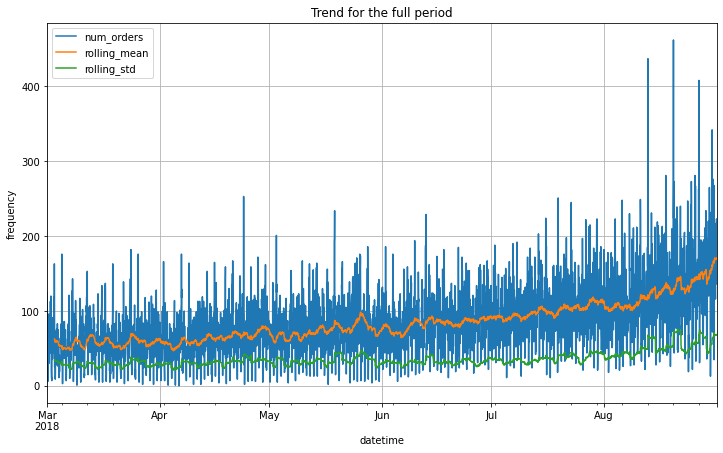

In [3]:
df_rolling_mean = df.resample('1H').sum()
df_rolling_mean['rolling_mean'] = df_rolling_mean['num_orders'].rolling(50).mean()
df_rolling_mean['rolling_std'] = df_rolling_mean['num_orders'].rolling(50).std()
plt.rcParams["figure.figsize"] = (12, 7)
df_rolling_mean.plot()
plt.grid()
plt.title('Trend for the full period')
plt.ylabel('frequency')

Let us take for analysis the period from 03/21/2018 to 03/23/2018

Text(0, 0.5, 'frequency')

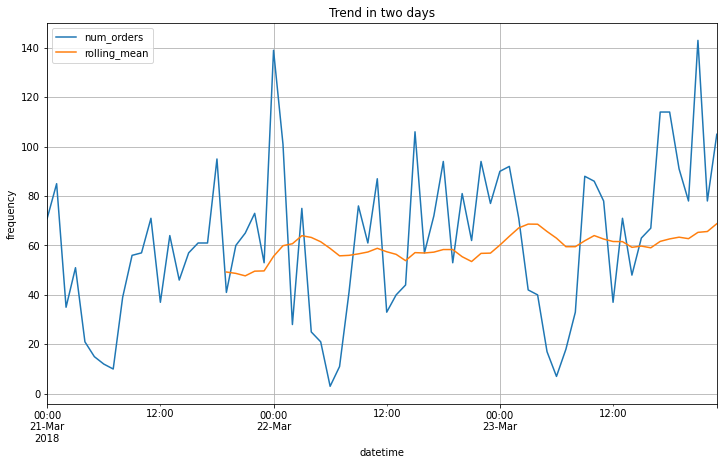

In [4]:
df_several_days = df['2018-03-21': '2018-03-23'].resample('1H').sum()
df_several_days['rolling_mean'] = df_several_days.rolling(20).mean()
df_several_days.plot()
plt.grid()
plt.title('Trend in two days')
plt.ylabel('frequency')

Let's move on to seasonality

Text(0, 0.5, 'frequency')

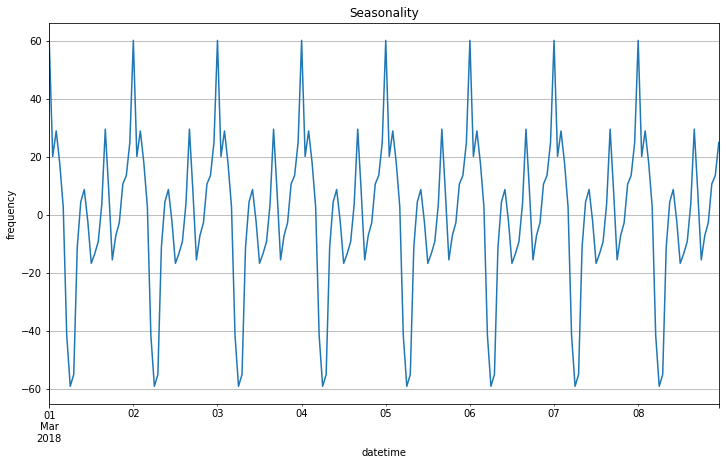

In [5]:
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid()
plt.ylabel('frequency')

Trend and remainder

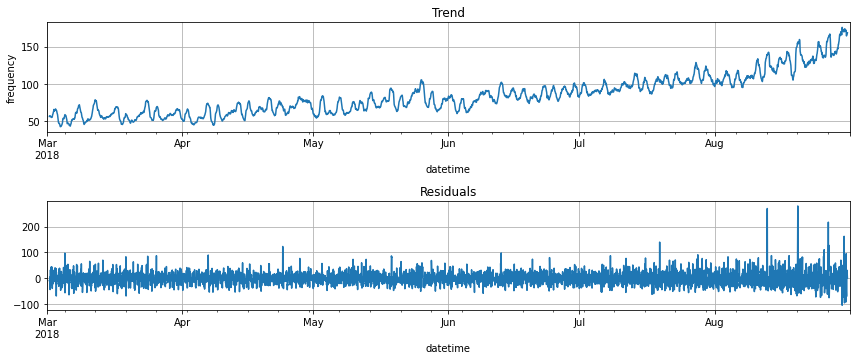

In [6]:
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid()
plt.ylabel('frequency')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.grid()
plt.tight_layout()

### Conclusion

Based on the data, we can say that the time series is not stationary (the mean and deviation changes)

Peak orders are observed in the afternoon and evening

## Model training

Let's create signs

In [7]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['sin_hour'] = np.sin(2*np.pi*df.index.hour/24)
    df['cos_hour'] = np.cos(2*np.pi*df.index.hour/24)
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag) 
    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(df, 170, 20)
print(df.head())

                     num_orders  day  dayofweek  hour  sin_hour  cos_hour  \
datetime                                                                    
2018-03-01 00:00:00         124    1          3     0  0.000000  1.000000   
2018-03-01 01:00:00          85    1          3     1  0.258819  0.965926   
2018-03-01 02:00:00          71    1          3     2  0.500000  0.866025   
2018-03-01 03:00:00          66    1          3     3  0.707107  0.707107   
2018-03-01 04:00:00          43    1          3     4  0.866025  0.500000   

                     lag_1  lag_2  lag_3  lag_4  ...  lag_162  lag_163  \
datetime                                         ...                     
2018-03-01 00:00:00    NaN    NaN    NaN    NaN  ...      NaN      NaN   
2018-03-01 01:00:00  124.0    NaN    NaN    NaN  ...      NaN      NaN   
2018-03-01 02:00:00   85.0  124.0    NaN    NaN  ...      NaN      NaN   
2018-03-01 03:00:00   71.0   85.0  124.0    NaN  ...      NaN      NaN   
2018-03-01 04:00

Let's divide our data into test and training samples

In [8]:
train, test = train_test_split(df, shuffle=False, test_size = 0.1, random_state = 12345)
print('Проверка минимального и максимального значений индексов для тренировочного датасета: ', 
      train.index.min(), train.index.max())
print('Проверка минимального и максимального значений индексов для тестового датасета: ', 
      test.index.min(), test.index.max())
train = train.dropna()
train, valid = train_test_split(train, shuffle=False, test_size=0.3, random_state=12345)

Проверка минимального и максимального значений индексов для тренировочного датасета:  2018-03-01 00:00:00 2018-08-13 13:00:00
Проверка минимального и максимального значений индексов для тестового датасета:  2018-08-13 14:00:00 2018-08-31 23:00:00


In [9]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
features_valid = valid.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']

<b>Moving on to linear regression</b>

In [10]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predict_lr_valid = model_lr.predict(features_valid)
rmse_lr_valid = mean_squared_error(np.array(target_valid), predict_lr_valid)**0.5
print('Качество модели Linear Regression на валидационной выборке (корень из средней квадратичной ошибки):', rmse_lr_valid)

Качество модели Linear Regression на валидационной выборке (корень из средней квадратичной ошибки): 25.746070612901633


<b>CatBoost</b>

In [11]:
model_cb = CatBoostRegressor(random_state = 12345, iterations = 100)
parameters_cb = {'depth': range(6, 11),
                 'learning_rate': [0.001, 0.01, 0.05, 0.1]}
search_cb = RandomizedSearchCV(model_cb, parameters_cb, cv = 5, n_jobs = -1, random_state = 12345)
search_cb.fit(features_train, target_train, verbose = 100)
best_cb = search_cb.best_estimator_
predict_cb_valid = best_cb.predict(features_valid)
rmse_cb_valid = mean_squared_error(np.array(target_valid), predict_cb_valid)**0.5
print('Качество модели CatBoost на валидационной выборке (корень из средней квадратичной ошибки):', rmse_cb_valid)

0:	learn: 33.6412825	total: 352ms	remaining: 34.8s
99:	learn: 23.0265790	total: 20s	remaining: 0us
0:	learn: 33.7868578	total: 330ms	remaining: 32.7s
99:	learn: 23.2301987	total: 21s	remaining: 0us
0:	learn: 33.4891992	total: 329ms	remaining: 32.6s
99:	learn: 22.6776040	total: 20.2s	remaining: 0us
0:	learn: 32.4942653	total: 316ms	remaining: 31.3s
99:	learn: 22.1384112	total: 20.2s	remaining: 0us
0:	learn: 32.8369695	total: 336ms	remaining: 33.3s
99:	learn: 22.2202004	total: 20.5s	remaining: 0us
0:	learn: 33.7954219	total: 170ms	remaining: 16.8s
99:	learn: 32.1794007	total: 10.7s	remaining: 0us
0:	learn: 33.9309863	total: 162ms	remaining: 16s
99:	learn: 32.3277574	total: 10.1s	remaining: 0us
0:	learn: 33.6496513	total: 154ms	remaining: 15.2s
99:	learn: 32.0141023	total: 10.6s	remaining: 0us
0:	learn: 32.6413675	total: 175ms	remaining: 17.3s
99:	learn: 31.0768955	total: 10.8s	remaining: 0us
0:	learn: 32.9775860	total: 179ms	remaining: 17.7s
99:	learn: 31.3736542	total: 10.7s	remaining: 

<b>LightGBM</b>

In [12]:
model_lgb = lgb.LGBMRegressor(random_state=12345)
parameters_lgb = {'depth': range(6, 11),
                 'learning_rate': [0.001, 0.01, 0.05, 0.1],
                 'n_estimators': range(100, 501, 50)}
search_lgb = RandomizedSearchCV(model_lgb, parameters_lgb, cv = 5, n_jobs = -1, random_state = 12345)
search_lgb.fit(features_train, target_train)
best_lgb = search_lgb.best_estimator_
predict_lgb_valid = best_lgb.predict(features_valid)
rmse_lgb_valid = mean_squared_error(np.array(target_valid), predict_lgb_valid)**0.5
print('Качество модели LighGBM на валидационной выборке (корень из средней квадратичной ошибки):', rmse_lgb_valid)

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown param

In [13]:
data_model = [['LinearRegression', rmse_lr_valid], 
              ['CatBoost', rmse_cb_valid], 
              ['LightGBM', rmse_lgb_valid]]
columns_model = ['model', 'rmse']
table_model = pd.DataFrame(data = data_model, columns = columns_model)
table_model

,model,rmse
0,LinearRegression,25.746071
1,CatBoost,27.012443
2,LightGBM,27.313142


## Testing

<b>Linear regression</b>

In [14]:
predict_lr_test = model_lr.predict(features_test)
rmse_lr_test = mean_squared_error(np.array(target_test), predict_lr_test)**0.5
print('Качество модели Linear Regression на тестовой выборке (корень из средней квадратичной ошибки):', rmse_lr_test)

Качество модели Linear Regression на тестовой выборке (корень из средней квадратичной ошибки): 36.23479586254028


## Conclusion

For our project, the linear regression model is best suited. Both in quality and time.

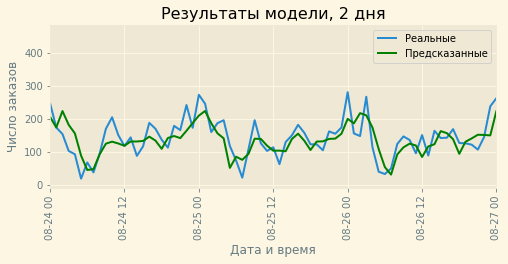

<AxesSubplot:title={'center':'Результат модели, 2 дня'}, xlabel='datetime'>

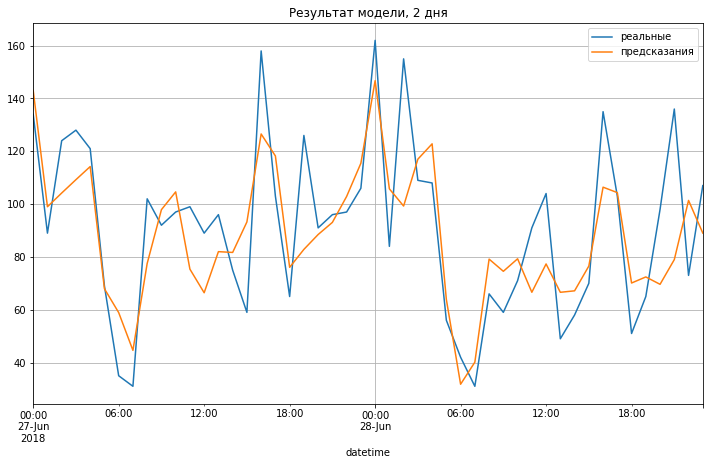

In [59]:
df_total = target_valid.to_frame(name='реальные')
df_total['предсказания'] = predict_lr_valid

df_total_2_days = df_total.loc[df_total.index < '2018-06-29 00:00:00']

df_total_2_days.plot(grid=True, title='Результат модели, 2 дня')